# Analisis Sentimen App MyPertamina
- **Nama:** NANTHA SEUTIA
- **Email:** ombakrinai@gmail.com

# Library

In [4]:
# 1. Install library yang dibutuhkan
!pip install google-play-scraper
!pip install Sastrawi

# 2. Import Library Utama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import re
import nltk
import string
import csv
import requests
import pickle
import os

# 3. Download NLTK resources BEFORE importing word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# 4. Import Google Play Scraper untuk mengambil ulasan aplikasi
from google_play_scraper import app, reviews, Sort, reviews_all

# 5. Import Sastrawi untuk Stemming dan Stopword Removal
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# 6. Import tambahan untuk pemrosesan teks dan visualisasi
from io import StringIO
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder

# 7. Library untuk TF-IDF dan BoW
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# 8. Model dan Evaluasi
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 9. Word2Vec untuk Representasi Teks
from gensim.models import Word2Vec

# 10. For Downloading file
from google.colab import files

# 11. Cache for stemming
from functools import lru_cache

# 12. SMOTE
from imblearn.over_sampling import SMOTE

!pip3 freeze > requirements.txt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Pengumpulan Data

1. Web scraping menggunakan Google Play Scraper.
2. Dataset memiliki minimal 10.000 sampel.
3. Pemberian label kelas sentimen berdasarkan leksikon Bahasa Indonesia (positif, negatif, netral).


In [5]:
# 2. Data Gathering
# URL file CSV di GitHub
github_url = "https://raw.githubusercontent.com/esnanta/data-analysis-sentiment-mypertamina/main/dataset/mypertamina_reviews.csv"
# Membaca CSV langsung dari URL menjadi DataFrame
reviews_df = pd.read_csv(github_url, encoding="utf-8")

# Tampilkan beberapa baris pertama untuk verifikasi
reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,8eb604e7-6b35-4c77-9a01-7da325e46204,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi yang sangat buruk,isi data berlapis, ...",1,27,4.6.6,2025-02-10 23:53:44,"Hai, Sobat. Mimin sampaikan, mengambil foto ST...",2025-02-11 11:02:12,4.6.6
1,a4994116-a3c1-4a46-9001-1bfdfa10b9a2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Tadinya sdh bisa registrasi mypertamina dan sd...,1,96,4.6.6,2025-02-01 05:17:32,"Hai, Sobat Zen. Mohon maaf atas ketidaknyamana...",2025-02-01 08:25:03,4.6.6
2,46e5bca6-88fb-4b2a-98aa-03a815d8f7a9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Makin kesini makin di persulit, mulai dari sud...",1,22,4.6.6,2025-02-08 21:37:29,"Hai, Sobat Julia. Mohon maaf atas ketidaknyama...",2025-02-09 08:37:36,4.6.6
3,b2e0aacc-4222-446b-aa61-dc3b8e850fde,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"ambil foto nge blur terus heran, pdhal kamera ...",1,1,4.6.6,2025-02-14 13:27:04,"Hai, Sobat Yanti. Mohon maaf atas ketidaknyama...",2025-02-15 09:35:06,4.6.6
4,bda93d55-5a29-4807-abda-121993dea84e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasinya sangat mempersulit untuk fitur fot...,1,0,4.6.6,2025-02-15 01:44:20,"Hai, Sobat Cahyaning. Mimin bantu sampaikan pr...",2025-02-15 09:21:49,4.6.6


In [6]:
# Tampilkan info data
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146629 entries, 0 to 146628
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              146629 non-null  object
 1   userName              146629 non-null  object
 2   userImage             146629 non-null  object
 3   content               146625 non-null  object
 4   score                 146629 non-null  int64 
 5   thumbsUpCount         146629 non-null  int64 
 6   reviewCreatedVersion  121852 non-null  object
 7   at                    146629 non-null  object
 8   replyContent          17731 non-null   object
 9   repliedAt             17731 non-null   object
 10  appVersion            121852 non-null  object
dtypes: int64(2), object(9)
memory usage: 12.3+ MB


In [7]:
# Hapus baris yang memiliki nilai yang hilang
clean_review_df = reviews_df.dropna()

# Hapus baris duplikat (menggunakan hasil dropna sebelumnya)
clean_review_df = clean_review_df.drop_duplicates()

# Tampilkan informasi dataset setelah dibersihkan
clean_review_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15632 entries, 0 to 146459
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              15632 non-null  object
 1   userName              15632 non-null  object
 2   userImage             15632 non-null  object
 3   content               15632 non-null  object
 4   score                 15632 non-null  int64 
 5   thumbsUpCount         15632 non-null  int64 
 6   reviewCreatedVersion  15632 non-null  object
 7   at                    15632 non-null  object
 8   replyContent          15632 non-null  object
 9   repliedAt             15632 non-null  object
 10  appVersion            15632 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.4+ MB


# Preprocessing Data
1. Cleaning data
2. Case folding (lowercase)
3. Tokenization
4. Stopword Removal

In [8]:
# 3. Processing Data
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
    text = re.sub(r'(.)\1+', r'\1', text)  # Hilangkan karakter berulang (contoh: "baguuuuus" -> "bagus"),
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text):
    # Menggabungkan stopwords Bahasa Indonesia dan Bahasa Inggris
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords_en = set(stopwords.words('english'))
    listStopwords.update(listStopwords_en)

    # Tambahan stopwords khusus untuk analisis sentimen ulasan MyPertamina
    # Alasan:
    # - Kata-kata seperti "pertamina", "aplikasi", "mypertamina", dan "update" muncul secara konsisten di setiap ulasan
    #   sehingga tidak memberikan informasi sentiment spesifik.
    # - Ekspresi informal dan filler seperti "iya", "gak", "sih", "dong", "deh", "nih", dll. umumnya tidak
    #   memberikan konteks emosional yang signifikan.
    # - Penambahan beberapa variasi kata negatif/informal seperti "nggak" dan kata penguat umum yang sering muncul.

    filler_stopwords = [
        "iya", "yaa", "gak", "nggak", "nya", "na", "sih", "ku", "di", "ga", "ya",
        "gaa", "loh", "kah", "woi", "woii", "woy", "dong", "deh", "nih", "ap",
        "tp", "sy", "sdh", "tdk", "gimana", "kali", "ok", "tolong", "moga", "blm",
        "lg", "pa","sat", "min", "mhn", "kartu", "hp", "stnk", "mohon", "cs", "bm",
        "klo", "masa", "kok", "knp", "kenapa", "gitu", "liat", "lihat", "dapet",
        "dapat", "yah", "gmn", "utk", "trus"
    ]

    general_stopwords = [
        "update", "pertamina", "aplikasi", "mypertamina",
        "aja", "udah", "belum", "sekali", "pakai", "pake", "data", "buka",
        "scan", "upload", "baru", "versi", "spbu", "struk" , "foto", "baca",
        "coba", "baru", "daftar", "masuk", "login", "barcode", "undian", "kupon",
        "sistem", "akun", "ktp", "bayar", "hasil", "tingkat", "kendaraan",
        "transaksi", "energi", "proses", "ulang", "moga", "ternyata", "kode",
        "beli", "kalo", "habis", "pakai", "bikin", "mobil", "poin",
        "verifikasi", "foto","baca","baru", "baik", "subsidi", "otp",
        "download", "unduh", "verifikasi", "info", "informasi",
        "nik", "tulis", "nomor", "orang", "koneksi", "bilang", "apk", "server"
    ]

    listStopwords.update(filler_stopwords)
    listStopwords.update(general_stopwords)

    filtered = [word for word in text if word not in listStopwords]
    return filtered

# Membuat objek stemmer hanya sekali
factory = StemmerFactory()
stemmer = factory.create_stemmer()

@lru_cache(maxsize=10000)  # Cache untuk 10.000 kata unik
def cached_stem(word: str) -> str:
    return stemmer.stem(word)

def stemmingText(words: list) -> list:
    return [cached_stem(word) for word in words]  # Proses setiap kata dengan caching

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [9]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih",
              "wts": "jual", "wtt": "tukar", "bgt": "banget",
              "maks": "maksimal", "aja":"saja", "yg":"yang",
			        "gak":"tidak","gk":"tidak", "ngak":"tidak", "maf":"maaf",
              "sesuai banget":"sangat sesuai", "pas":"sesuai"}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [10]:
# Stemming bisa diabaikan jika menggunakan lexicon-based sentiment analysis
# dengan kamus yang tidak berbasis kata dasar.

# 1. Cleaning: Hapus karakter khusus, URL, angka, dsb.
clean_review_df['text_clean'] = clean_review_df['content'].apply(cleaningText)

# 2. Normalisasi: Ubah semua teks menjadi huruf kecil
clean_review_df['text_casefolding'] = clean_review_df['text_clean'].apply(casefoldingText)

# 3. Perbaikan Slang: Ganti kata-kata slang dengan bentuk standarnya
clean_review_df['text_slangwords'] = clean_review_df['text_casefolding'].apply(fix_slangwords)

# --- Persiapan Teks untuk Lexicon-Based & Model Klasik ---
# 4. Tokenisasi: Memecah teks menjadi token (kata)
clean_review_df['text_tokenized'] = clean_review_df['text_slangwords'].apply(tokenizingText)

# 5. Filtering: Hapus stopwords menggunakan fungsi filteringText
clean_review_df['text_filtered'] = clean_review_df['text_tokenized'].apply(filteringText)

# 6. (Opsional) Stemming: Hanya jika ingin digunakan untuk model klasik seperti SVM/RandomForest
# clean_review_df['text_stemmed'] = clean_review_df['text_filtered'].apply(stemmingText)

# 7. Gabungkan token menjadi kalimat kembali
# Kolom untuk lexicon-based labeling atau model klasik (misalnya menggunakan TF-IDF)
clean_review_df['text_akhir'] = clean_review_df['text_filtered'].apply(toSentence)

# Pelabelan Data

1. Gunakan leksikon data positif dan negatif untuk Bahasa Indonesia
2. Kolom sasaran adalah text_akhir
3. Distribusi Sentimen



In [11]:
# 4. Data Labelling
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [12]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    words = text.split()  # Split the text into words!

    for word in words:
        if word in lexicon_positive:
            score = score + lexicon_positive[word]

    for word in words:
        if word in lexicon_negative:
            score = score + lexicon_negative[word]

    polarity = ''
    if score > 0:  # Corrected the condition here (no need for >= 0)
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'  # Explicitly set neutral

    return score, polarity

In [13]:
results = clean_review_df['text_akhir'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_review_df['polarity_score'] = results[0]
clean_review_df['polarity'] = results[1]
clean_review_df['polarity'].value_counts()

,count
polarity,
neutral,5969
negative,5132
positive,4531


In [14]:
label_encoder = LabelEncoder()

# Fit dan transform kolom 'polarity' menjadi numerik
clean_review_df['label'] = label_encoder.fit_transform(clean_review_df['polarity'])

# Tampilkan mapping label
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Tampilkan 5 baris teratas dengan label
clean_review_df[['content','polarity', 'label']].head()

{'negative': 0, 'neutral': 1, 'positive': 2}


,content,polarity,label
0,"Aplikasi yang sangat buruk,isi data berlapis, ...",negative,0
1,Tadinya sdh bisa registrasi mypertamina dan sd...,negative,0
2,"Makin kesini makin di persulit, mulai dari sud...",negative,0
3,"ambil foto nge blur terus heran, pdhal kamera ...",negative,0
4,Aplikasinya sangat mempersulit untuk fitur fot...,negative,0


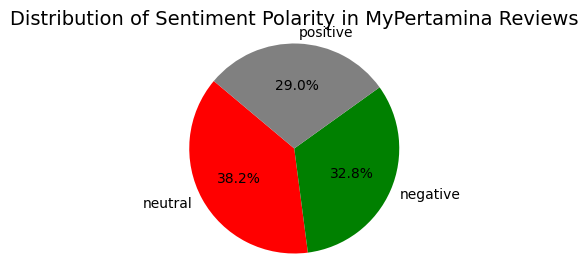

In [15]:
# Calculate value counts of 'polarity' column
polarity_counts = clean_review_df['polarity'].value_counts()

# Create a DataFrame from the value counts (optional, but good practice)
df = pd.DataFrame({'polarity': polarity_counts.index, 'count': polarity_counts.values})

# Plotting the pie chart
plt.figure(figsize=(4, 3))  # Adjust figure size for better readability

# Define colors
colors = ['red', 'green', 'gray']

# Create the pie chart
plt.pie(df['count'], labels=df['polarity'], colors=colors,
        autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('Distribution of Sentiment Polarity in MyPertamina Reviews', fontsize=14)

# Ensure the circle's proportion
plt.axis('equal')

# Show the plot
plt.show()

Distribusi menunjukkan bahwa persepsi pengguna terhadap MyPertamina cenderung beragam, dengan mayoritas ulasan bersifat netral hingga negatif. Hal ini bisa menjadi masukan bagi pengembang aplikasi untuk meningkatkan pengalaman pengguna agar lebih banyak ulasan positif di masa mendatang.

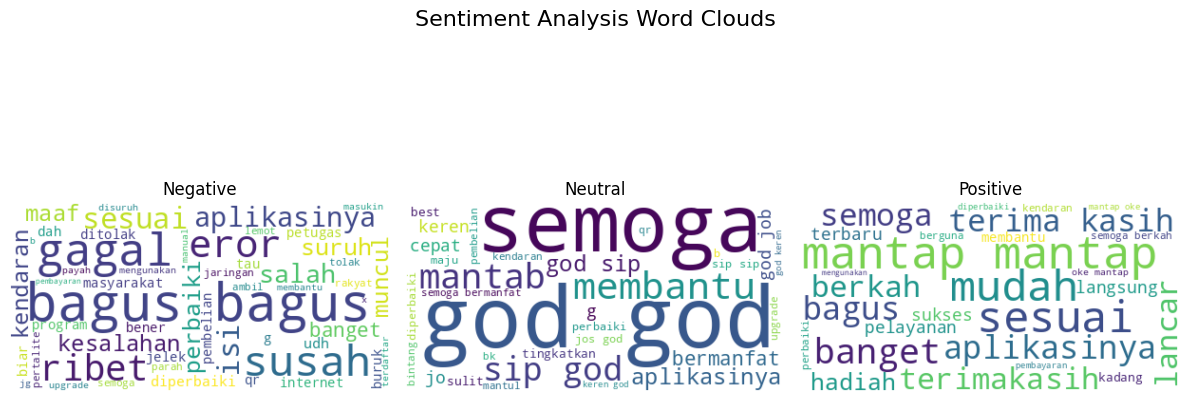

In [16]:
# Function to generate word cloud (no display inside the function)
def generate_wordcloud(text):
    wordcloud = WordCloud(width=400, height=200,  # Smaller size
                          background_color='white',
                          max_words=100,  # Fewer words for clarity
                          min_font_size=8).generate(' '.join(text))
    return wordcloud


# Separate text by polarity
positive_text = clean_review_df[clean_review_df['polarity'] == 'positive']['text_akhir']
negative_text = clean_review_df[clean_review_df['polarity'] == 'negative']['text_akhir']
neutral_text = clean_review_df[clean_review_df['polarity'] == 'neutral']['text_akhir']

# Generate word clouds
positive_wc = generate_wordcloud(positive_text)
negative_wc = generate_wordcloud(negative_text)
neutral_wc = generate_wordcloud(neutral_text)

# Create a figure with subplots
fig = plt.figure(figsize=(12, 6))  # Adjust figure size

# Create a gridspec layout for better spacing
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 1 row, 3 columns

# Plotting the word clouds

ax2 = plt.subplot(gs[0])
ax2.imshow(negative_wc, interpolation='bilinear')
ax2.set_title('Negative', fontsize=12)
ax2.axis("off")

ax3 = plt.subplot(gs[1])
ax3.imshow(neutral_wc, interpolation='bilinear')
ax3.set_title('Neutral', fontsize=12)
ax3.axis("off")

ax1 = plt.subplot(gs[2])
ax1.imshow(positive_wc, interpolation='bilinear')
ax1.set_title('Positive', fontsize=12)
ax1.axis("off")

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.suptitle("Sentiment Analysis Word Clouds", fontsize=16)  # Overall title
plt.show()

# Pelatihan Machine Learning
1. Ekstraksi Fitur: Term Frequency-Inverse Document Frequency (TF-IDF)

Akurasi Model (SVM) dengan SMOTE: 0.9226095299008634

Laporan Klasifikasi (SVM) dengan SMOTE:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      1027
           1       0.91      0.95      0.93      1194
           2       0.94      0.89      0.92       906

    accuracy                           0.92      3127
   macro avg       0.92      0.92      0.92      3127
weighted avg       0.92      0.92      0.92      3127

Akurasi Model (RandomForest) dengan SMOTE: 0.9146146466261592

Laporan Klasifikasi (RandomForest) dengan SMOTE:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90      1027
           1       0.92      0.96      0.94      1194
           2       0.93      0.87      0.90       906

    accuracy                           0.91      3127
   macro avg       0.92      0.91      0.91      3127
weighted avg       0.91      0.91      0.91      3127



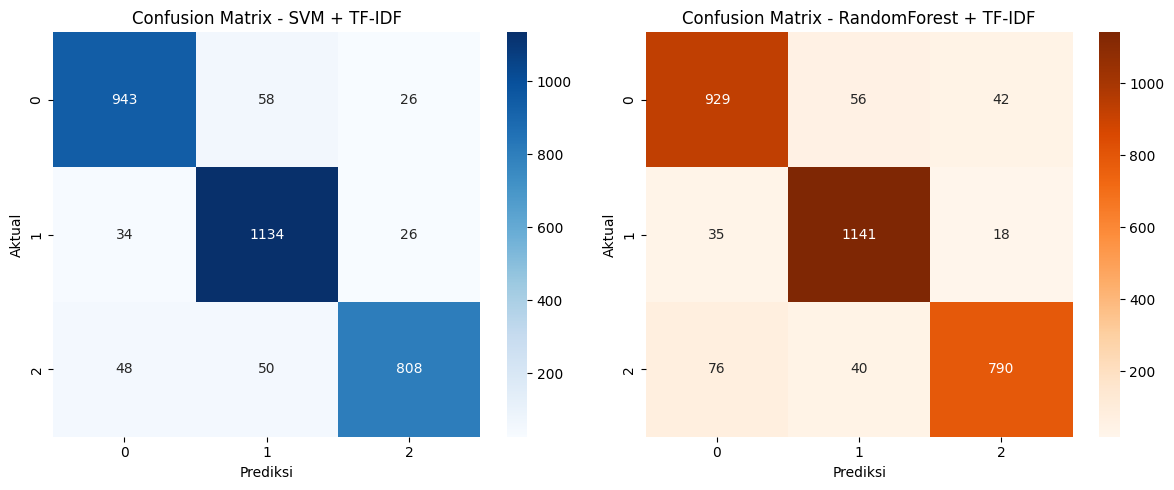

In [17]:
# 1. Ekstraksi Fitur dengan TF-IDF dengan parameter yang diperbarui
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000, min_df=5)
X = vectorizer.fit_transform(clean_review_df['text_akhir'])
y = clean_review_df['label']

# 2. Bagi dataset menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify disarankan jika ingin pembagian kelas seimbang
)

# 3. Karena X_train berupa sparse matrix, konversi ke dense untuk SMOTE
X_train_dense = X_train.toarray()

# 4. Terapkan SMOTE pada data training
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_dense, y_train)

# 5. Ubah X_test menjadi dense untuk konsistensi
X_test_dense = X_test.toarray()

# --- Evaluasi Model SVM ---
# 6. Model SVM dengan class_weight='balanced'
svm_model_tfidf = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_model_tfidf.fit(X_train_res, y_train_res)

# 7. Evaluasi Model SVM
y_pred_svm = svm_model_tfidf.predict(X_test_dense)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Akurasi Model (SVM) dengan SMOTE:", accuracy_svm)
print("\nLaporan Klasifikasi (SVM) dengan SMOTE:\n", classification_report(y_test, y_pred_svm))

# --- Evaluasi Model RandomForest ---
# 8. Model RandomForest dengan class_weight='balanced'
rf_model_tfidf = RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced')
rf_model_tfidf.fit(X_train_res, y_train_res)

# 9. Evaluasi Model RandomForest
y_pred_rf = rf_model_tfidf.predict(X_test_dense)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Akurasi Model (RandomForest) dengan SMOTE:", accuracy_rf)
print("\nLaporan Klasifikasi (RandomForest) dengan SMOTE:\n", classification_report(y_test, y_pred_rf))

# --- Menampilkan Confusion Matrix secara berdampingan ---
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_rf = confusion_matrix(y_test, y_pred_rf)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix untuk Model SVM
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix - SVM + TF-IDF")
axes[0].set_xlabel("Prediksi")
axes[0].set_ylabel("Aktual")

# Confusion Matrix untuk Model RandomForest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title("Confusion Matrix - RandomForest + TF-IDF")
axes[1].set_xlabel("Prediksi")
axes[1].set_ylabel("Aktual")

plt.tight_layout()  # Agar plot tidak saling tumpang tindih
plt.show()

2. Ekstraksi Fitur: Word2Vec

Akurasi Model (RandomForest dengan Word2Vec & SMOTE): 0.7882954908858331

Laporan Klasifikasi (RandomForest dengan Word2Vec & SMOTE):
               precision    recall  f1-score   support

           0       0.72      0.85      0.78      1049
           1       0.92      0.78      0.85      1183
           2       0.74      0.72      0.73       895

    accuracy                           0.79      3127
   macro avg       0.79      0.79      0.78      3127
weighted avg       0.80      0.79      0.79      3127



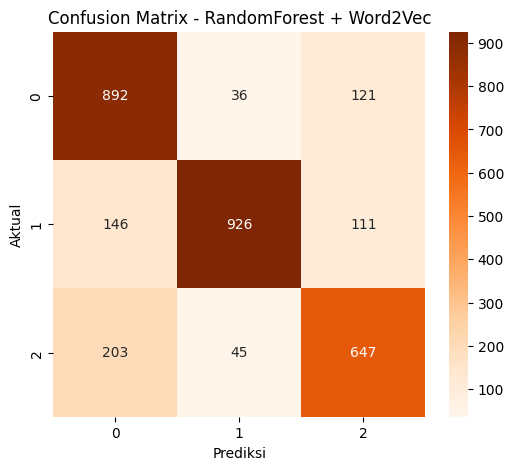

In [18]:
# 1. Ekstraksi Fitur dengan Word2Vec
sentences = [text.split() for text in clean_review_df['text_akhir']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

def get_word2vec_features(text):
    words = text.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if not word_vectors:
        return np.zeros(100)
    return np.mean(word_vectors, axis=0)

features_list = [get_word2vec_features(text) for text in clean_review_df['text_akhir']]
X = np.vstack(features_list)
y = clean_review_df['label']

# 2. Bagi dataset menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Terapkan SMOTE pada data training (Word2Vec sudah dense)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 4. Model RandomForest dengan class_weight='balanced'
rf_model_word2vec = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model_word2vec.fit(X_train_res, y_train_res)

# 5. Evaluasi Model RandomForest dengan Word2Vec
y_pred_rf = rf_model_word2vec.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Akurasi Model (RandomForest dengan Word2Vec & SMOTE):", accuracy_rf)
print("\nLaporan Klasifikasi (RandomForest dengan Word2Vec & SMOTE):\n", classification_report(y_test, y_pred_rf))

# Tambahkan Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - RandomForest + Word2Vec")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

# Testing
Output berupa kelas kategorikal (contoh: negatif, netral, dan positif).

In [19]:
# Simpan model SVM dengan TF-IDF
with open('svm_model_tfidf.pkl', 'wb') as file:
    pickle.dump(svm_model_tfidf, file)

# Simpan model Random Forest dengan TF-IDF
with open('rf_model_tfidf.pkl', 'wb') as file:
    pickle.dump(rf_model_tfidf, file)

# Simpan model Random Forest dengan Word2Vec
with open('rf_model_word2vec.pkl', 'wb') as file:
    pickle.dump(rf_model_word2vec, file)

# Simpan TF-IDF Vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

# Simpan Word2Vec model
w2v_model.save("word2vec_model.bin")

print("Semua model telah disimpan!\n")

# ========================
# MEMUAT KEMBALI MODEL
# ========================

# Load model SVM TF-IDF
with open('svm_model_tfidf.pkl', 'rb') as file:
    loaded_svm_model_tfidf = pickle.load(file)

# Load model Random Forest TF-IDF
with open('rf_model_tfidf.pkl', 'rb') as file:
    loaded_rf_model_tfidf = pickle.load(file)

# Load model Random Forest Word2Vec
with open('rf_model_word2vec.pkl', 'rb') as file:
    loaded_rf_model_word2vec = pickle.load(file)

# Load TF-IDF Vectorizer
with open('tfidf_vectorizer.pkl', 'rb') as vectorizer_file:
    loaded_vectorizer = pickle.load(vectorizer_file)

# Load Word2Vec model
loaded_w2v_model = Word2Vec.load("word2vec_model.bin")


# ========================
# INFERENCE (PREDIKSI)
# ========================

# Contoh review baru yang akan diprediksi
new_reviews = [
    "Aplikasi ini sangat jelek, banyak bug",      # Negatif
    "Saya sangat suka aplikasi ini, keren!",      # Positif
    "Aplikasinya biasa saja, tidak buruk",        # Netral
    "Banyak fitur yang tidak berfungsi",          # Negatif
    "Aplikasi sangat membantu pekerjaan saya",    # Positif
    "Tidak terlalu bagus tapi bisa digunakan"     # Netral
]

# Transformasi review baru dengan TF-IDF dan konversi ke dense array
X_new_tfidf = loaded_vectorizer.transform(new_reviews).toarray()

# 1. Prediksi menggunakan TF-IDF + SVM
pred_svm_tfidf = loaded_svm_model_tfidf.predict(X_new_tfidf)

# 2. Prediksi menggunakan TF-IDF + RandomForest
pred_rf_tfidf = loaded_rf_model_tfidf.predict(X_new_tfidf)

# 3. Prediksi menggunakan Word2Vec + RandomForest
def get_word2vec_features(text):
    words = text.split()
    word_vectors = [loaded_w2v_model.wv[word] for word in words if word in loaded_w2v_model.wv]
    if len(word_vectors) == 0:
        return np.zeros(100)  # Sesuaikan dengan vector_size=100
    return np.mean(word_vectors, axis=0)

# Ekstraksi fitur Word2Vec untuk review baru
X_new_word2vec = np.vstack([get_word2vec_features(text) for text in new_reviews])

# Prediksi menggunakan RandomForest dengan Word2Vec
pred_rf_word2vec = loaded_rf_model_word2vec.predict(X_new_word2vec)

# Mapping Label Sentimen
label_mapping = {0: "Negatif", 1: "Netral", 2: "Positif"}

# ========================
# MENAMPILKAN HASIL PREDIKSI
# ========================
for review, label_svm, label_rf_tfidf, label_rf_word2vec in zip(new_reviews, pred_svm_tfidf, pred_rf_tfidf, pred_rf_word2vec):
    print(f"Review: {review}")
    print(f"  Prediksi SVM + TF-IDF: {label_mapping[label_svm]}")
    print(f"  Prediksi Random Forest + TF-IDF: {label_mapping[label_rf_tfidf]}")
    print(f"  Prediksi Random Forest + Word2Vec: {label_mapping[label_rf_word2vec]}\n")



Semua model telah disimpan!

Review: Aplikasi ini sangat jelek, banyak bug
  Prediksi SVM + TF-IDF: Negatif
  Prediksi Random Forest + TF-IDF: Negatif
  Prediksi Random Forest + Word2Vec: Netral

Review: Saya sangat suka aplikasi ini, keren!
  Prediksi SVM + TF-IDF: Positif
  Prediksi Random Forest + TF-IDF: Positif
  Prediksi Random Forest + Word2Vec: Positif

Review: Aplikasinya biasa saja, tidak buruk
  Prediksi SVM + TF-IDF: Negatif
  Prediksi Random Forest + TF-IDF: Negatif
  Prediksi Random Forest + Word2Vec: Negatif

Review: Banyak fitur yang tidak berfungsi
  Prediksi SVM + TF-IDF: Netral
  Prediksi Random Forest + TF-IDF: Netral
  Prediksi Random Forest + Word2Vec: Positif

Review: Aplikasi sangat membantu pekerjaan saya
  Prediksi SVM + TF-IDF: Netral
  Prediksi Random Forest + TF-IDF: Netral
  Prediksi Random Forest + Word2Vec: Netral

Review: Tidak terlalu bagus tapi bisa digunakan
  Prediksi SVM + TF-IDF: Negatif
  Prediksi Random Forest + TF-IDF: Negatif
  Prediksi Random

# Summary

1. SVM dengan TF-IDF + SMOTE

    * Akurasi tertinggi di antara ketiga model, yaitu 92,26%.
    * Performa precision, recall, dan f1-score yang merata di atas 0,90 untuk setiap kelas. Kelas 1 memiliki recall tertinggi (0,95), sedangkan kelas 2 memiliki precision tertinggi (0,94).
    * Model ini menunjukkan kemampuan klasifikasi yang kuat dan seimbang, sehingga sangat efektif untuk memisahkan ketiga kelas sentimen.
    * Berdasarkan diagram confusion matrix, jumlah misclassification cenderung sedikit salah memprediksi pada setiap kelas, khususnya kelas 0 dan kelas 2, sehingga menghasilkan akurasi keseluruhan yang lebih tinggi.

2. RandomForest dengan TF-IDF + SMOTE

    * Mencapai akurasi 91,46%, sedikit di bawah SVM namun masih tergolong tinggi.
    * Kelas 1 memiliki kinerja yang sangat baik dengan recall sebesar 0,96, menandakan model sangat handal dalam menangkap data pada kelas tersebut.
    * Kelas 2 juga terklasifikasi cukup baik dengan precision 0,93, menandakan tingkat kesalahan prediksi yang rendah saat model memprediksi kelas 2.

3. Confusion Matrix TF-IDF
    * Prediksi yang Benar:
        - SVM menunjukkan akurasi yang lebih baik pada kelas 0 dan kelas 2, dengan jumlah prediksi yang benar lebih tinggi dibandingkan RandomForest.
        - RandomForest lebih baik dalam memprediksi kelas 1, dengan jumlah kesalahan yang lebih sedikit dibandingkan SVM.
    * Prediksi yang Salah
        - RandomForest lebih banyak salah memprediksi kelas 0 sebagai kelas 2 dibandingkan SVM (42 vs. 26 kesalahan).
        - SVM lebih banyak salah memprediksi kelas 2 sebagai kelas 1 dibandingkan RandomForest (50 vs. 40 kesalahan).
        - Kedua model memiliki kesalahan prediksi yang cukup kecil pada kelas 1, tetapi RandomForest lebih stabil dengan jumlah kesalahan yang lebih sedikit.
    * Kesalahan prediksi paling sering terjadi antara kelas 0 ↔ 2 dan kelas 1 ↔ 2, yang menunjukkan adanya kemiripan karakteristik teks dalam kategori tersebut.


5. Confusion Matrix Word2Vec
    * Prediksi yang benar (diagonal utama):
        - Kelas 0: 902 sampel diklasifikasikan dengan benar.
        - Kelas 1: 920 sampel diklasifikasikan dengan benar.
        - Kelas 2: 640 sampel diklasifikasikan dengan benar.
    * Prediksi yang salah:
        - Kelas 2 masih sering diklasifikasikan sebagai kelas 0 (211 kasus) dan kelas 1 (44 kasus).
        - Kelas 1 juga memiliki kesalahan yang cukup merata, salah diprediksi sebagai kelas 0 (149 kasus) dan kelas 2 (114 kasus).